# 1. Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer, PorterStemmer

from textblob import TextBlob
from deep_translator import GoogleTranslator
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import torch

c:\Coding\VsCode\Coding\AI\AI-Projects\Pertalite Sentiment Analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\korez\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\korez\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\korez\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('dataset_tiktok-comments-scraper_2025-11-17_12-14-29-915.csv')
df.head()

,text,diggCount,replyCommentTotal,createTimeISO,uniqueId,videoWebUrl,uid,cid,avatarThumbnail
0,"setiap bahlil ngomong, kiamat maju 1jam",87436,977,2025-10-09T03:10:07.000Z,ikmalbhrlm,https://www.tiktok.com/@dj_donny/video/7559032...,6962567982649541633,7559053960901559058,https://p19-common-sign.tiktokcdn-us.com/tos-a...
1,buku panduan,49090,185,2025-10-09T05:09:12.000Z,bang.kholis96,https://www.tiktok.com/@dj_donny/video/7559032...,7384053991606486022,7559084636891480853,https://p16-common-sign.tiktokcdn-us.com/tos-a...
2,kayaknya si bahlil terinspirasi dari karakter ...,17011,105,2025-10-09T05:47:57.000Z,user4444_119,https://www.tiktok.com/@dj_donny/video/7559032...,6962785913933235202,7559094616738661121,https://p16-common-sign.tiktokcdn-us.com/tos-a...
3,kok mirip ya😹,14029,134,2025-10-09T05:04:40.000Z,symfahri3,https://www.tiktok.com/@dj_donny/video/7559032...,6632464555773607937,7559083478210904849,https://p16-common-sign.tiktokcdn-us.com/tos-a...
4,campuran etanol 10%. korupsinya berapa persen? 🤣,30811,60,2025-10-09T02:23:03.000Z,whyfirmann,https://www.tiktok.com/@dj_donny/video/7559032...,6991736734669325314,7559041842743132936,https://p16-common-sign.tiktokcdn-us.com/tos-a...


In [ ]:
df.drop(columns=['uniqueId','videoWebUrl','uid','cid','avatarThumbnail','diggCount','replyCommentTotal'],inplace=True)

In [27]:
df.duplicated().sum()

np.int64(0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               1942 non-null   object
 1   diggCount          2000 non-null   int64 
 2   replyCommentTotal  2000 non-null   int64 
 3   createTimeISO      2000 non-null   object
dtypes: int64(2), object(2)
memory usage: 62.6+ KB


In [6]:
df.dropna(inplace=True)

In [7]:
df.head()

,text,diggCount,replyCommentTotal,createTimeISO
0,"setiap bahlil ngomong, kiamat maju 1jam",87436,977,2025-10-09T03:10:07.000Z
1,buku panduan,49090,185,2025-10-09T05:09:12.000Z
2,kayaknya si bahlil terinspirasi dari karakter ...,17011,105,2025-10-09T05:47:57.000Z
3,kok mirip ya😹,14029,134,2025-10-09T05:04:40.000Z
4,campuran etanol 10%. korupsinya berapa persen? 🤣,30811,60,2025-10-09T02:23:03.000Z


In [8]:
df['createTimeISO'] = pd.to_datetime(df['createTimeISO'])
df.head()

,text,diggCount,replyCommentTotal,createTimeISO
0,"setiap bahlil ngomong, kiamat maju 1jam",87436,977,2025-10-09 03:10:07+00:00
1,buku panduan,49090,185,2025-10-09 05:09:12+00:00
2,kayaknya si bahlil terinspirasi dari karakter ...,17011,105,2025-10-09 05:47:57+00:00
3,kok mirip ya😹,14029,134,2025-10-09 05:04:40+00:00
4,campuran etanol 10%. korupsinya berapa persen? 🤣,30811,60,2025-10-09 02:23:03+00:00


In [9]:
emoji_pattern = re.compile(
    "["
    "\U0001F600-\U0001F64F"  # emoticons
    "\U0001F300-\U0001F5FF"  # symbols & pictographs
    "\U0001F680-\U0001F6FF"  # transport & map symbols
    "\U0001F700-\U0001F77F"  # alchemical
    "\U0001F780-\U0001F7FF"  # geometric extended
    "\U0001F800-\U0001F8FF"  # supplemental arrows
    "\U0001F900-\U0001F9FF"  # supplemental symbols + pictographs
    "\U0001FA00-\U0001FA6F"  # chess, symbols
    "\U0001FA70-\U0001FAFF"  # symbols extended-A
    "\U00002700-\U000027BF"  # dingbats
    "\U00002600-\U000026FF"  # misc symbols
    "\U0001F1E0-\U0001F1FF"  # flags
    "]+",
    flags=re.UNICODE
)

# Scan your DataFrame column
# 1. Collect emojis per row WITHOUT adding a new DataFrame column
emoji_pattern = re.compile(r"\X", flags=re.UNICODE)

# Function to extract only emojis (single grapheme clusters)
def extract_emojis(text):
    chars = emoji_pattern.findall(text)
    return [c for c in chars if any(ord(x) > 1000 for x in c)]  # filters out non-emoji

# If the notebook or previous run created `df['emojis']`, drop it now to avoid keeping it
if 'emojis' in df.columns:
    df.drop(columns=['emojis'], inplace=True)

# Use a local Series to avoid adding a new column
emojis_per_row = df['text'].astype(str).apply(extract_emojis)

# 2. Count emoji presence per row (unique per row)
emoji_row_counts = {}

for emoji_list_row in emojis_per_row:
    unique_in_row = set(emoji_list_row)
    for e in unique_in_row:
        emoji_row_counts[e] = emoji_row_counts.get(e, 0) + 1

# 3. Build stats DataFrame
emoji_stats = pd.DataFrame([
    {
        "emoji": e,
        "rows_with_emoji": count,
        "percentage_of_rows": round((count / len(df)) * 100, 4),
    }
    for e, count in emoji_row_counts.items()
])

emoji_stats = emoji_stats.sort_values("rows_with_emoji", ascending=False)

# Keep only frequently observed emojis (more than 5 rows), without writing them to df
emoji_stats = emoji_stats[emoji_stats['rows_with_emoji'] > 5].reset_index(drop=True)
emoji_list = list(emoji_stats['emoji'])

# Print summary for quick inspection
emoji_list

['🤣',
 '🗿',
 '😂',
 '😭',
 '😁',
 '😹',
 '😏',
 '🔥',
 '🙏',
 '✅',
 '👍',
 '😅',
 '🤭',
 '🥰',
 '❌',
 '😡',
 '😌',
 '🥺',
 '❎',
 '😆']

In [10]:
# IndoBERT Sentiment Analysis Functions

# Load IndoBERT model (using a public alternative)
tokenizer = AutoTokenizer.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier")
model = AutoModelForSequenceClassification.from_pretrained("w11wo/indonesian-roberta-base-sentiment-classifier")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Expanded slang dictionary for better normalization of informal Indonesian text
slang_dict = {
    "gk": "tidak",
    "ga": "tidak",
    "bgt": "banget",
    "anjir": "anjir",
    "wkwk": "[laugh]",
    "haha": "[laugh]",
    "gemoy": "gemoy",
    "anjay": "anjay",
    "bacot": "bacot",
    "asik": "asyik",
    "mantap": "bagus",
    "jelek": "jelek",
    "oke": "baik",
    "iya": "ya",
    "syg": "sayang",
    "kk": "kakak",
    "abang": "abang",
    "sis": "saudara perempuan",
    "bro": "teman",
}

def clean_text(text):
    if pd.isna(text) or text.strip() == "":
        return ""
    text = text.lower()
    # Normalize repeated characters (e.g., "bangetttt" -> "banget") using proper backreferences
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)
    # Preserve emojis as they are critical sentiment signals in informal text like TikTok comments
    # Include emojis from emoji_list (those appearing in >5 rows)
    allowed_emojis = ''.join(emoji_list) if 'emoji_list' in globals() else ""
    allowed_chars = r"\w\s.!?#" + allowed_emojis
    text = re.sub(r"[^" + allowed_chars + r"]", " ", text)
    return text.strip()

def normalize_slang(text, slang_dict):
    if not text:
        return ""
    return " ".join([slang_dict.get(w, w) for w in text.split()])

def predict_indobert(text):
    if not text.strip():
        return "neutral", 0.0
    result = sentiment_pipeline(text)[0]
    return result["label"], float(result["score"])

Device set to use cpu


In [11]:
# Apply IndoBERT preprocessing and prediction
df['cleaned_text'] = df['text'].apply(clean_text)
df['normalized_text'] = df['cleaned_text'].apply(lambda x: normalize_slang(x, slang_dict))

# Predict sentiment using IndoBERT on normalized text (no stemming needed for transformer models with subword tokenization)
df['indobert_label'], df['indobert_score'] = zip(*df['normalized_text'].apply(predict_indobert))

# Categorize IndoBERT sentiment (assuming labels are 'LABEL_0', 'LABEL_1', etc.; adjust mapping if needed)
def categorize_indobert(label):
    if 'positive' in label.lower() or 'LABEL_1' in label:
        return 'positive'
    elif 'negative' in label.lower() or 'LABEL_0' in label:
        return 'negative'
    else:
        return 'neutral'

df['indobert_sentiment'] = df['indobert_label'].apply(categorize_indobert)

In [13]:
df.head()

,text,diggCount,replyCommentTotal,createTimeISO,cleaned_text,normalized_text,indobert_label,indobert_score,indobert_sentiment
0,"setiap bahlil ngomong, kiamat maju 1jam",87436,977,2025-10-09 03:10:07+00:00,setiap bahlil ngomong kiamat maju 1jam,setiap bahlil ngomong kiamat maju 1jam,neutral,0.976646,neutral
1,buku panduan,49090,185,2025-10-09 05:09:12+00:00,buku panduan,buku panduan,positive,0.551686,positive
2,kayaknya si bahlil terinspirasi dari karakter ...,17011,105,2025-10-09 05:47:57+00:00,kayaknya si bahlil terinspirasi dari karakter ...,kayaknya si bahlil terinspirasi dari karakter ...,positive,0.997089,positive
3,kok mirip ya😹,14029,134,2025-10-09 05:04:40+00:00,kok mirip ya😹,kok mirip ya😹,negative,0.817127,negative
4,campuran etanol 10%. korupsinya berapa persen? 🤣,30811,60,2025-10-09 02:23:03+00:00,campuran etanol 10 . korupsinya berapa persen? 🤣,campuran etanol 10 . korupsinya berapa persen? 🤣,negative,0.999304,negative


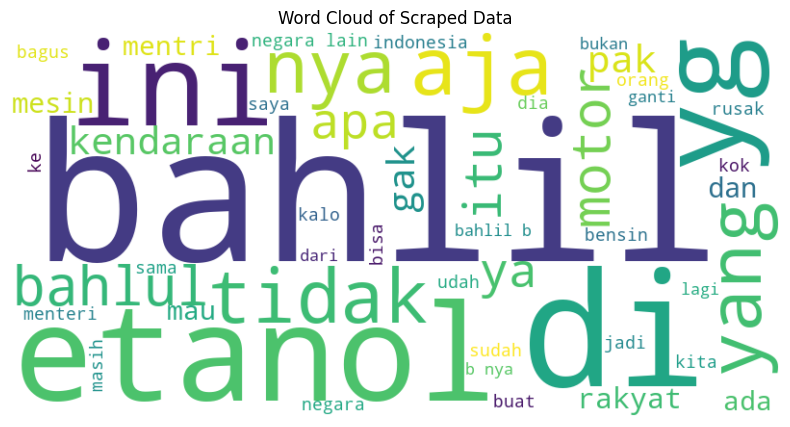

In [14]:
# Word Cloud for Translated Comments
all_text = ' '.join(df['normalized_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(all_text)

plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Scraped Data')
plt.show()

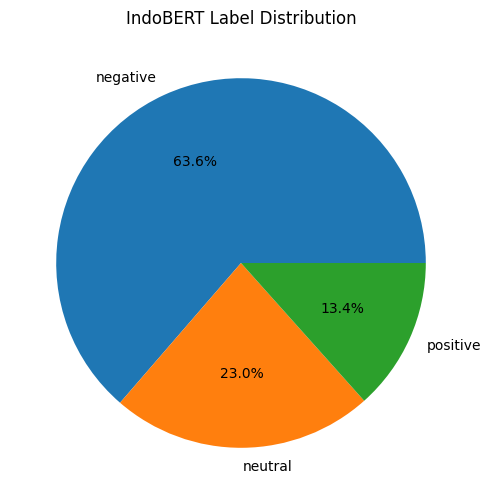

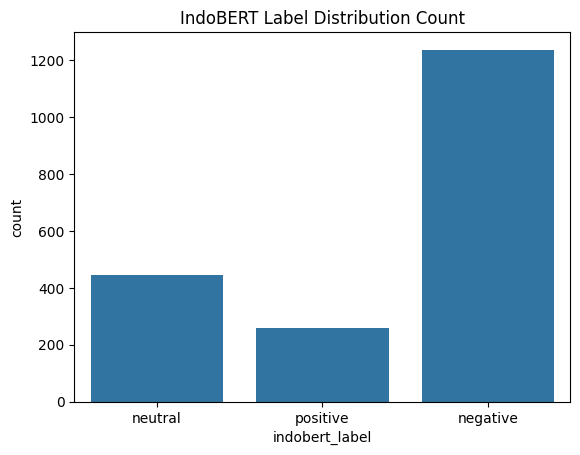

In [15]:
# Additional IndoBERT Visualizations

# Pie chart for IndoBERT labels
df['indobert_label'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6))
plt.title('IndoBERT Label Distribution')
plt.ylabel('')
plt.show()

sns.countplot(x=df['indobert_label'])
plt.title('IndoBERT Label Distribution Count')
plt.show()

In [24]:
df[df['indobert_score'] <=.65]

,text,diggCount,replyCommentTotal,createTimeISO,cleaned_text,normalized_text,indobert_label,indobert_score,indobert_sentiment
1,buku panduan,49090,185,2025-10-09 05:09:12+00:00,buku panduan,buku panduan,2,0.551686,2
14,"Good job my minister, I have already approved ...",43,2,2025-10-09 02:01:01+00:00,good job my minister i have already approved ...,good job my minister i have already approved t...,1,0.453195,1
17,Bahlil : Misi sedang dilaksanakan boss,1083,11,2025-10-09 04:38:01+00:00,bahlil misi sedang dilaksanakan boss,bahlil misi sedang dilaksanakan boss,0,0.621482,0
25,fungsi Bahlil di Kementerian apa sih?,12,5,2025-10-10 04:21:22+00:00,fungsi bahlil di kementerian apa sih?,fungsi bahlil di kementerian apa sih?,0,0.555948,0
58,makasih bang udah bantu speak up manusia itu,5,0,2025-10-09 10:12:07+00:00,makasih bang udah bantu speak up manusia itu,makasih bang udah bantu speak up manusia itu,2,0.504868,2
...,...,...,...,...,...,...,...,...,...
1906,Bersihin rumahnya aja,1,0,2025-10-13 13:02:41+00:00,bersihin rumahnya aja,bersihin rumahnya aja,2,0.626866,2
1914,Minyak bersih 🤣. PETRONAS tidak perlu campur u...,1,0,2025-10-13 10:00:23+00:00,minyak bersih 🤣. petronas tidak perlu campur u...,minyak bersih 🤣. petronas tidak perlu campur u...,1,0.555120,1
1916,saran dari saya campur air kencing aja biar mu...,1,0,2025-10-13 08:38:40+00:00,saran dari saya campur air kencing aja biar mu...,saran dari saya campur air kencing aja biar mu...,2,0.428633,2
1924,@bahlil.lahadalia 🗿,1,0,2025-10-13 06:01:44+00:00,bahlil.lahadalia 🗿,bahlil.lahadalia 🗿,2,0.612048,2


In [ ]:
label_maps = {
    'positive':2,
    'neutral':1,
    'negative':0
}

df['indobert_label'] = df['indobert_label'].map(label_maps)
df['indobert_sentiment'] = df['indobert_sentiment'].map(label_maps)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1942 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   text                1942 non-null   object             
 1   diggCount           1942 non-null   int64              
 2   replyCommentTotal   1942 non-null   int64              
 3   createTimeISO       1942 non-null   datetime64[ns, UTC]
 4   cleaned_text        1942 non-null   object             
 5   normalized_text     1942 non-null   object             
 6   indobert_label      1942 non-null   int64              
 7   indobert_score      1942 non-null   float64            
 8   indobert_sentiment  1942 non-null   int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(3)
memory usage: 151.7+ KB


In [ ]:
df.drop(columns=['indobert_score','indobert_sentiment',''], inplace=True)